# Create Embedding Features

In [1]:
# load libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [51]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [52]:
# see columns
train.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')

In [53]:
# features
bin_features = [col for col in train.columns if col.startswith("bin")]
nom_features = [col for col in train.columns if col.startswith("nom")]
ord_features = [col for col in train.columns if col.startswith("ord")]
time_features = ["day", "month"]

select_features = ["nom_0", "nom_1", "nom_2", "nom_3", "nom_4"]

In [54]:
# check selected features
train[select_features].describe()

,nom_0,nom_1,nom_2,nom_3,nom_4
count,230276,230276,230276,230276,230276
unique,3,6,6,6,4
top,Green,Trapezoid,Lion,Russia,Oboe
freq,97705,77650,77942,77758,70872


In [55]:
# encode text features
encoder = LabelEncoder()
for col in select_features:
    print(col)
    train[f"{col}_encoded"] = encoder.fit_transform(train[col])

nom_0
nom_1
nom_2
nom_3
nom_4


In [56]:
# encoded features
encoded_features = [col for col in train.columns if col.endswith("encoded")]

In [57]:
# train test split
xtrain, xtest, ytrain, ytest = train_test_split(
    # train[encoded_features],
    train[select_features],
    train["target"],
    test_size=0.33
)

xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((154284, 5), (75992, 5), (154284,), (75992,))

In [62]:
# create tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((
    dict(xtrain), ytrain)).batch(64)

test_ds = tf.data.Dataset.from_tensor_slices((
    dict(xtest), ytest)).batch(64)

In [65]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['nom_0'])
print('A batch of targets:', label_batch )

Every feature: ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
A batch of ages: tf.Tensor(
[b'Blue' b'Green' b'Blue' b'Green' b'Blue' b'Green' b'Green' b'Green'
 b'Blue' b'Red' b'Green' b'Blue' b'Red' b'Green' b'Green' b'Green'
 b'Green' b'Blue' b'Green' b'Green' b'Blue' b'Green' b'Red' b'Blue' b'Red'
 b'Blue' b'Blue' b'Red' b'Red' b'Green' b'Green' b'Red' b'Green' b'Red'
 b'Blue' b'Blue' b'Blue' b'Red' b'Blue' b'Red' b'Blue' b'Blue' b'Blue'
 b'Green' b'Green' b'Green' b'Blue' b'Blue' b'Green' b'Red' b'Red' b'Red'
 b'Green' b'Green' b'Blue' b'Blue' b'Red' b'Green' b'Red' b'Red' b'Blue'
 b'Green' b'Red' b'Green'], shape=(64,), dtype=string)
A batch of targets: tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.], shape=(64,), dtype=float64)


In [66]:
# function to encode category features
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
    else:
        index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    return lambda feature: encoder(index(feature))

In [75]:
# encode features
all_inputs = []
encoded_features = []

for header in select_features:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(
        name=header,
        dataset=train_ds,
        dtype='string',
        max_tokens=6
    )
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [77]:
# build model
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(512, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nom_0 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 nom_1 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 nom_2 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 nom_3 (InputLayer)             [(None, 1)]          0           []                               
                                                                                            

In [78]:
# compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

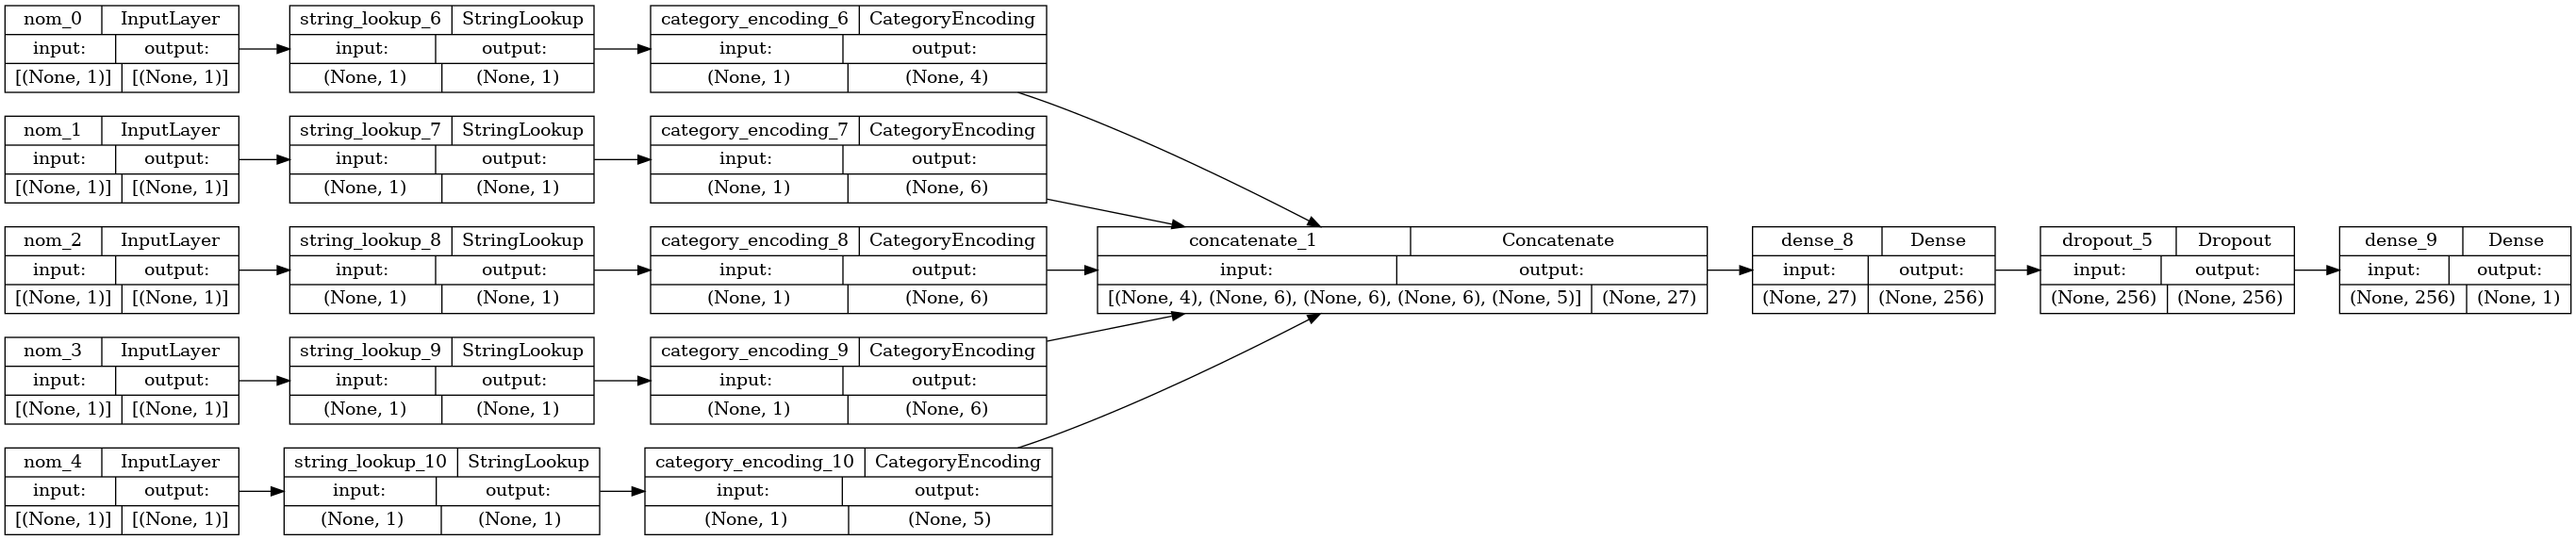

In [79]:
# view model architecture
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [80]:
# train
model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
2411/2411 [==============================] - 15s 6ms/step - loss: 0.6045 - accuracy: 0.6933 - val_loss: nan - val_accuracy: 0.6952
Epoch 2/10
2411/2411 [==============================] - 14s 6ms/step - loss: 0.6023 - accuracy: 0.6933 - val_loss: nan - val_accuracy: 0.6952
Epoch 3/10
2411/2411 [==============================] - 14s 6ms/step - loss: 0.6016 - accuracy: 0.6933 - val_loss: nan - val_accuracy: 0.6952
Epoch 4/10
2411/2411 [==============================] - 14s 6ms/step - loss: 0.6016 - accuracy: 0.6933 - val_loss: nan - val_accuracy: 0.6952
Epoch 5/10
2411/2411 [==============================] - 14s 6ms/step - loss: 0.6013 - accuracy: 0.6933 - val_loss: nan - val_accuracy: 0.6952
Epoch 6/10
2411/2411 [==============================] - 14s 6ms/step - loss: 0.6012 - accuracy: 0.6934 - val_loss: nan - val_accuracy: 0.6952
Epoch 7/10
2411/2411 [==============================] - 14s 6ms/step - loss: 0.6007 - accuracy: 0.6934 - val_loss: nan - val_accuracy: 0.6952
Epoch 

In [81]:
# view accuracy
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1188/1188 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.6952
Accuracy 0.6951784491539001


## Get Embedding as Features

In [98]:
# embedding as features
pd.DataFrame(model.get_weights()[5]).T

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-0.025200,-0.103046,-0.335440,0.153323,0.046861,-0.286533,0.181960,-0.112748,-0.097444,-0.029182,...,-0.360858,0.024833,0.082827,-0.517598,0.013934,0.075632,0.148929,-0.130230,-0.274273,-0.069140
1,0.079435,-0.279858,0.012224,0.081781,-0.041802,-0.242572,-0.378652,-0.144587,0.210997,0.099597,...,-0.287958,0.032357,-0.088890,-0.255290,0.247094,-0.124052,-0.102077,-0.037612,-0.025471,-0.131424
2,0.142277,-0.065261,0.053317,-0.118745,-0.099721,-0.253591,-0.081795,-0.038979,-0.202857,-0.066554,...,-0.198876,-0.110571,-0.174732,-0.014609,0.137886,0.120277,0.004315,-0.127033,-0.319119,-0.254716
3,-0.087550,-0.048845,-0.288311,0.038803,0.113234,-0.201875,0.230770,-0.188379,-0.143931,-0.154108,...,-0.094317,0.030609,-0.279583,-0.109409,0.091262,0.061110,0.146504,-0.223540,-0.184354,-0.049583
4,-0.004241,-0.146434,-0.236790,0.084777,-0.168220,-0.282685,0.187914,0.095295,-0.147140,0.168299,...,0.049647,0.092448,-0.129840,-0.242138,-0.046348,-0.035250,0.065061,-0.194069,0.108786,0.093494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.018442,-0.201700,0.102344,-0.123910,-0.047451,-0.092537,-0.184842,-0.000268,-0.028651,0.014716,...,0.099728,-0.092230,-0.094734,-0.081818,0.074837,0.107256,-0.126926,0.035523,0.081837,-0.115201
252,-0.016818,-0.083734,0.053145,-0.045379,0.215752,0.082404,-0.068454,0.029701,0.057234,0.070723,...,-0.098709,0.072484,-0.024793,0.170251,0.139400,-0.101634,-0.071771,0.064500,0.120059,-0.188327
253,-0.058258,-0.118384,0.119938,-0.046423,-0.016012,-0.025504,-0.080429,-0.008987,0.027290,-0.050522,...,-0.102769,-0.122492,0.056479,0.231265,0.003056,0.132814,0.039870,-0.077364,-0.019422,0.084636
254,0.110076,-0.133495,-0.294720,-0.045913,-0.160385,0.099027,-0.046442,-0.021684,-0.008858,-0.172591,...,-0.023144,0.007639,-0.172981,-0.172180,-0.034073,0.074928,-0.025199,-0.006078,0.016118,0.020888
